In [1]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1
from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D
from utils.model_utils import unwrap_model

from config.data_param_config import data_merge_config
from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict


/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=-1,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=6,
                    help=f"Number of class num use to train")

parser.add_argument("-m", "--model_name", type=str,
                    help=f"Config name of model used for training")

parser.add_argument("--data_merge_param", type=str, default=None,
                    help=f"Data merge config name, find in config/data_param_config")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=["-m", "4cnnmp_128"])
else:
    args = parser.parse_args()

In [3]:
L.seed_everything(args.random_seed)

Seed set to 42


42

In [15]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    **channel_param_dict[args.model_name],).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes      | Out sizes    
--------------------------------------------------------------------------
0  | cnn      | Sequential  | 283 K  | [10, 6, 257]  | [10, 256, 1] 
1  | cnn.0    | Conv1d      | 1.8 K  | [10, 6, 257]  | [10, 32, 249]
2  | cnn.1    | MaxPool1d   | 0      | [10, 32, 249] | [10, 32, 83] 
3  | cnn.2    | BatchNorm1d | 64     | [10, 32, 83]  | [10, 32, 83] 
4  | cnn.3    | ReLU        | 0      | [10, 32, 83]  | [10, 32, 83] 
5  | cnn.4    | Conv1d      | 18.5 K | [10, 32, 83]  | [10, 64, 75] 
6  | cnn.5    | MaxPool1d   | 0      | [10, 64, 75]  | [10, 64, 25] 
7  | cnn.6    | BatchNorm1d | 128    | [10, 64, 25]  | [10, 64, 25] 
8  | cnn.7    | ReLU        | 0      | [10, 64, 25]  | [10, 64, 25] 
9  | cnn.8    | Conv1d      | 65.7 K | [10, 64, 25]  | [10, 128, 18]
10 | cnn.9    | MaxPool1d   | 0      | [10, 128, 18] | [10, 128, 6] 
11 | cnn.10   | BatchNorm1d | 256    | [10, 128, 6]  | [10, 128, 6] 
12 | cnn.11   | ReLU        

In [16]:
n_epochs = 20000
patience = n_epochs//100

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name = f"10.2_classify/{args.model_name}-{args.class_num}-{args.data_merge_param}-{args.train_limit_data}-{args.random_seed}"

In [ ]:
data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
if args.data_merge_param:
    label_merge_dict = data_merge_config[args.data_merge_param]
    print("before merge train", np.unique(data_module.train_label, return_counts=True))
    print("before merge val", np.unique(data_module.val_label, return_counts=True))
    print("before merge test", np.unique(data_module.test_label, return_counts=True))
    data_module.set_train_val_test_pred_merge_data(
        data_module.train_data,
        data_module.train_label,
        data_module.val_data,
        data_module.val_label,
        data_module.test_data,
        data_module.test_label,
        label_merge_dict,
        train_limit_number = args.train_limit_data,
        val_limit_number=1000,
        test_limit_number=1000,
        seed=42)
    print("after merge train", np.unique(data_module.train_label, return_counts=True))
    print("after merge val", np.unique(data_module.val_label, return_counts=True))
    print("after merge test", np.unique(data_module.test_label, return_counts=True))

In [ ]:
L.seed_everything(args.random_seed)

if args.data_merge_param:
    net = Classifier1DMaxPoolBNModel(
        optimizer = optimizer,
        optimizer_param = optimizer_param, 
        **channel_param_dict[args.model_name],
        out_class_num = len(data_merge_config[args.data_merge_param]),
    )
else:
    net = Classifier1DMaxPoolBNModel(
        optimizer = optimizer,
        optimizer_param = optimizer_param, 
        **channel_param_dict[args.model_name],
        out_class_num = args.class_num,
    )

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    )

print("np.unique(data_module.train_label, return_counts=True)", np.unique(data_module.train_label, return_counts=True))

trainer.fit(model=net, datamodule=data_module)
trainer_test_dict = trainer.logged_metrics

trainer.test(model=net, datamodule=data_module)
trainer_test_dict.update(trainer.logged_metrics)

print("trainer.logger.log_dir", trainer.logger.log_dir)

for key in trainer_test_dict.keys():
    trainer_test_dict[key] = trainer_test_dict[key].item()

with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
    json.dump(trainer_test_dict, f, indent=4)

with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

In [15]:
args.eval_mode = 1
if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "10.2_classify/{}-{}-{}-{}-{}"
    args.data_merge_param = "1"
    result_save_dict = {}
    raw_result_save_dict = {}

    for args.model_name in "4cnn_128 4cnn_64".split(" "):
        for args.class_num in [8]:
            for args.train_limit_data in "1000 5000".split(" "):
                args.train_limit_data = int(args.train_limit_data)
                for args.random_seed in "42".split():
                    
                    save_model_folder = log_save_name.format(args.model_name, args.class_num, args.data_merge_param, args.train_limit_data, args.random_seed)
                    save_model_dir = os.path.join(log_save_dir, save_model_folder)
                    print(save_model_folder)
                    weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                    print(save_model_folder, weight)
    
                    net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
                        
                    data_module = ALDataModule_v1.load_from_checkpoint(weight)
                    data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
                    if args.data_merge_param:
                        label_merge_dict = data_merge_config[args.data_merge_param]
                        print("before merge train", np.unique(data_module.train_label, return_counts=True))
                        print("before merge val", np.unique(data_module.val_label, return_counts=True))
                        print("before merge test", np.unique(data_module.test_label, return_counts=True))
                        data_module.set_train_val_test_pred_merge_data(
                            data_module.train_data,
                            data_module.train_label,
                            data_module.val_data,
                            data_module.val_label,
                            data_module.test_data,
                            data_module.test_label,
                            label_merge_dict,
                            train_limit_number = args.train_limit_data,
                            val_limit_number=1000,
                            test_limit_number=1000,
                            seed=42)
    
                    trainer = L.Trainer()
                    trainer.test(model=net, datamodule=data_module, verbose=False)
                    test_acc = trainer.logged_metrics["test_acc"]
                    result_save_dict[save_model_folder] = test_acc

                    output = trainer.predict(model=net, datamodule=data_module)
                    pred = torch.argmax(torch.concat(output), dim=1)
                    gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
        
                    pred_ravel = pred.numpy()
                    gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
        
                    cf = confusion_matrix(gt_ravel, pred_ravel)
                    raw_result_save_dict[save_model_folder] = cf.tolist()


10.2_classify/4cnn_128-8-1-1000-42
10.2_classify/4cnn_128-8-1-1000-42 lightning_logs/10.2_classify/4cnn_128-8-1-1000-42/version_0/checkpoints/sample_epoch=39-step=120-val_loss=0.270295.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000, 1000, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), arr

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 145.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 128.39it/s]
10.2_classify/4cnn_128-8-1-5000-42
10.2_classify/4cnn_128-8-1-5000-42 lightning_logs/10.2_classify/4cnn_128-8-1-5000-42/version_0/checkpoints/sample_epoch=09-step=130-val_loss=0.217190.ckpt
limit_and_set_train_data limit_number= 5000
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 5000


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([5000, 5000, 5000, 5000, 5000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 153.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 179.18it/s]
10.2_classify/4cnn_64-8-1-1000-42
10.2_classify/4cnn_64-8-1-1000-42 lightning_logs/10.2_classify/4cnn_64-8-1-1000-42/version_0/checkpoints/sample_epoch=39-step=120-val_loss=0.244989.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 1000
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000, 1000, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), arr

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 100.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 143.02it/s]
10.2_classify/4cnn_64-8-1-5000-42
10.2_classify/4cnn_64-8-1-5000-42 lightning_logs/10.2_classify/4cnn_64-8-1-5000-42/version_0/checkpoints/sample_epoch=29-step=390-val_loss=0.196677.ckpt
limit_and_set_train_data limit_number= 5000
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 5000


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([5000, 5000, 5000, 5000, 5000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 116.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 189.58it/s]


In [16]:
raw_result_save_dict

{'10.2_classify/4cnn_128-8-1-1000-42': [[976, 0, 0, 6, 18],
  [39, 913, 0, 39, 9],
  [3, 4, 859, 3, 0],
  [25, 6, 0, 944, 25],
  [168, 2, 0, 11, 819]],
 '10.2_classify/4cnn_128-8-1-5000-42': [[991, 0, 0, 2, 7],
  [47, 938, 0, 12, 3],
  [4, 5, 859, 1, 0],
  [33, 12, 1, 944, 10],
  [210, 2, 0, 6, 782]],
 '10.2_classify/4cnn_64-8-1-1000-42': [[943, 1, 0, 8, 48],
  [24, 944, 0, 23, 9],
  [3, 7, 857, 2, 0],
  [20, 13, 0, 952, 15],
  [115, 4, 0, 19, 862]],
 '10.2_classify/4cnn_64-8-1-5000-42': [[972, 4, 0, 2, 22],
  [26, 956, 1, 13, 4],
  [3, 5, 861, 0, 0],
  [29, 6, 0, 954, 11],
  [130, 6, 0, 11, 853]]}

In [17]:
with open("save_data/classifier_merge5_result.json", "w") as f:
    json.dump(raw_result_save_dict, f, indent=2)

/tmp/ipykernel_44487/4051846858.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


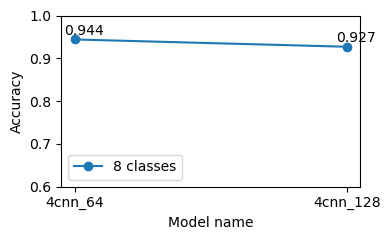

In [14]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(4, 2.5))
    args.random_seed = 42
    args.train_limit_data = "5000"
    args.data_merge_param = "1"
    
    for args.class_num in [8]:
        x = []
        for args.model_name in "4cnn_64 4cnn_128".split(" "):
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.data_merge_param, args.train_limit_data, args.random_seed)
            x.append(round(result_save_dict[save_model_folder].item(), 3))

        ax.plot(x, label=f"{args.class_num} classes", marker="o")
        for i, j in enumerate(x):
            ax.annotate(str(j),xy=(i-0.04,j+0.01))
        
    # ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model name')
    
    ax.set_xticks([0, 1], ["4cnn_64", "4cnn_128"])
    ax.set_ylim(0.6, 1)
    
    ax.legend()
    plt.tight_layout()